In [1]:

from numpy.random import seed

import tensorflow as tf
tf.random.set_seed(101)
seed(101)
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
os.listdir("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive")

['aug_dir',
 'base_dir',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [5]:


base_dir = 'C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

class_list = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

for item in class_list:
    train_class_dir = os.path.join(train_dir, item)
    if not os.path.exists(train_class_dir):
        os.mkdir(train_class_dir)

    val_class_dir = os.path.join(val_dir, item)
    if not os.path.exists(val_class_dir):
        os.mkdir(val_class_dir)


### Create Train and Val Sets

In [6]:
df_data = pd.read_csv("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\HAM10000_metadata.csv")

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Create a stratified val set

In [7]:

df = df_data.groupby('lesion_id').count()

df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.shape

(5514, 7)

In [8]:

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [9]:
df_data['duplicates'].value_counts()

duplicates
no_duplicates     5514
has_duplicates    4501
Name: count, dtype: int64

In [10]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [11]:
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [12]:
df_val['dx'].value_counts()

dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

### Create a train set that excludes images that are in the val set

In [13]:

def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [14]:
df_train['dx'].value_counts()

dx
nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: count, dtype: int64

In [15]:
df_val['dx'].value_counts()

dx
nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: count, dtype: int64

### Transfer the Images into the Folders

In [16]:
df_data.set_index('image_id', inplace=True)

In [17]:
folder_1 = os.listdir("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\HAM10000_images_part_1")
folder_2 = os.listdir("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\HAM10000_images_part_2")

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\HAM10000_images_part_1", fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\HAM10000_images_part_2", fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)



for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\HAM10000_images_part_1", fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\HAM10000_images_part_2", fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)
        

KeyboardInterrupt: 

In [17]:
print(len(os.listdir("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\nv")))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\mel')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\bkl')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\bcc')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\akiec')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\vasc')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\df')))

5954
6020
6020
6008
6017
6040
6010


In [18]:
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\val_dir\\nv')))


751


### Copy the train images  into aug_dir

In [ ]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    aug_dir = 'C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\' + img_class)

    for fname in img_list:
            src = os.path.join('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\' + img_class

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    
    num_aug_images_wanted = 6000 
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    shutil.rmtree("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\aug_dir")

In [ ]:

print(len(os.listdir("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\nv")))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\mel')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\bkl')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\bcc')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\akiec')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\vasc')))
print(len(os.listdir('C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir\\df')))

In [20]:
print(len(os.listdir('E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\nv')))
print(len(os.listdir('E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\mel')))
print(len(os.listdir('E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\bkl')))
print(len(os.listdir('E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\bcc')))
print(len(os.listdir('E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\akiec')))
print(len(os.listdir('E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\vasc')))
print(len(os.listdir('E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\df')))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\Files_From_C\\Dataset\\archive\\base_dir\\val_dir\\nv'

### Visualize 50 augmented images

In [20]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

for i in range(0, num_batches):
    imgs, labels = next(aug_datagen)

    # (Previous code...)

    # Inside the loop to generate augmented images
    plots(imgs, titles=None)

### Set Up the Generators

In [29]:
train_path = 'C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\train_dir'
valid_path = 'C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\archive\\base_dir\\val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [30]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 42069 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


# **CNN**

In [18]:
from keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [20]:
from keras.models import Sequential
import keras.models

In [23]:
input_shape = (224,224, 3)
num_classes = 7
model=Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                      

In [24]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)


In [25]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    run_eagerly=True  # Enable eager execution during training
)


In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
epochs = 30
batch_size = 10
history = model.fit(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs, verbose=1,
                  callbacks=[learning_rate_reduction])


Epoch 1/30

698/908 [======================>.......] - ETA: 5:27 - loss: 1.9824 - accuracy: 0.3499

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024F53BEE0C0>
Traceback (most recent call last):

  File "C:\Users\ragha\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\ragha\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\ragha\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\engine\data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\engine\data_adapter.py", line 1064, in generator_fn
    yield x[i]
          ~^^^

  File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\utils\image_utils.py", line 423, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\ragha\anaconda3\Lib\site-packages\PIL\Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024F53BEE0C0>


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
# Save the weights after 5 epochs
model.save_weights('model_weights_epoch5.h5')


In [25]:
from sklearn.metrics import classification_report,confusion_matrix

In [30]:
loaded_model = tf.keras.models.load_model("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\skin-disease-classification-main\\skin-disease-classification-main\\model.h5")

In [32]:
from tensorflow.keras.utils import plot_model

plot_model(loaded_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:

loaded_model = tf.keras.models.load_model("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\skin-disease-classification-main\\skin-disease-classification-main\\model.h5")
a = \
loaded_model.evaluate_generator(test_batches, 
                        steps=len(df_val))
your_evaluation_steps = 2

evaluation_metrics = loaded_model.evaluate(a, steps=your_evaluation_steps)

# Print the accuracy
accuracy_index = loaded_model.metrics_names.index('accuracy')  # Replace with 'acc' if using older versions of Keras
accuracy = evaluation_metrics[accuracy_index]
print(f'Accuracy: {accuracy}')


C:\Users\ragha\AppData\Local\Temp\ipykernel_26244\2441406275.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loaded_model.evaluate_generator(test_batches,


ValueError: in user code:

    File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ragha\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (1,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(1,), dtype=float32)
      • training=False
      • mask=None


In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'test_batches' is your test generator
loaded_model = tf.keras.models.load_model("C:\\Users\\ragha\\OneDrive\\Documents\\Skin disease identification materials\\skin-disease-classification-main\\skin-disease-classification-main\\model.h5")

your_evaluation_steps = 2

# Note: evaluate_generator is deprecated, but you can still use it for now
evaluation_metrics = loaded_model.evaluate_generator(test_batches, steps=your_evaluation_steps)

# Print the accuracy
accuracy_index = loaded_model.metrics_names.index('accuracy')  # Replace with 'acc' if using older versions of Keras
accuracy = evaluation_metrics[accuracy_index]
print(f'Accuracy: {accuracy}')

C:\Users\ragha\AppData\Local\Temp\ipykernel_26244\578787802.py:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation_metrics = loaded_model.evaluate_generator(test_batches, steps=your_evaluation_steps)


Accuracy: 0.5


In [37]:
model.metrics_names

NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()



plt.show()



NameError: name 'history' is not defined

In [ ]:
test_labels = test_batches.classes

In [ ]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

  3/938 [..............................] - ETA: 31s 

C:\Users\deepa\AppData\Local\Temp\ipykernel_12496\4245227744.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)


938/938 [==============================] - 33s 35ms/step


In [ ]:
predictions.shape

(938, 7)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
test_labels.shape

(938,)

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 26   0   0   0   0   0   0]
 [ 30   0   0   0   0   0   0]
 [ 72   0   1   2   0   0   0]
 [  6   0   0   0   0   0   0]
 [ 39   0   0   0   0   0   0]
 [724   0  18   9   0   0   0]
 [ 11   0   0   0   0   0   0]]


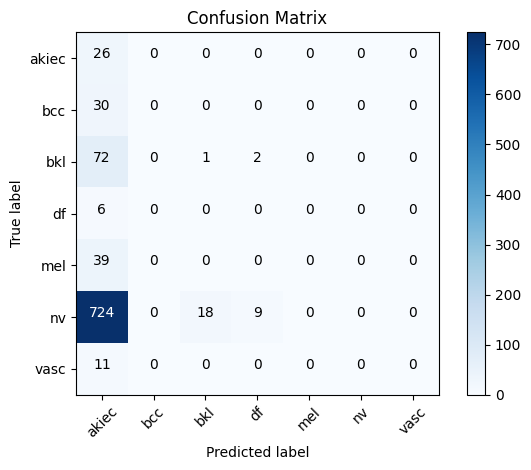

In [ ]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.03      1.00      0.06        26
         bcc       0.00      0.00      0.00        30
         bkl       0.05      0.01      0.02        75
          df       0.00      0.00      0.00         6
         mel       0.00      0.00      0.00        39
          nv       0.00      0.00      0.00       751
        vasc       0.00      0.00      0.00        11

    accuracy                           0.03       938
   macro avg       0.01      0.14      0.01       938
weighted avg       0.01      0.03      0.00       938



C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('E:\\Files_From_C\\skin-disease-classification-main\\model.h5')

# Define your evaluation data generator (replace 'your_evaluation_data_generator' with your actual data generator)
evaluation_data_generator = your_evaluation_data_generator
eval_steps = len(evaluation_data_generator)

# Evaluate the model
evaluation_metrics = loaded_model.evaluate(evaluation_data_generator, steps=eval_steps)

# The evaluation_metrics variable now contains the evaluation results
print(f"Loss: {evaluation_metrics[0]}, Accuracy: {evaluation_metrics[1]}")


NameError: name 'your_evaluation_data_generator' is not defined

To classify or predict

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("E:\\Files_From_C\\skin-disease-classification-main\\model.h5")


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np

# Load and preprocess the input image
img_path = "E:\\Files_From_C\\Dataset\\archive\\HAM10000_images_part_1\\ISIC_0024688.jpg"
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size based on your model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


In [ ]:
predictions = loaded_model.predict(img_array)


1/1 [==============================] - 0s 316ms/step


In [ ]:
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv','vasc']   # Replace with your actual class labels
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

print(f'The model predicts: {predicted_class_label}')


The model predicts: mel


# **MobileNet**

In [ ]:
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 42067 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


### Modify MobileNet Model

In [ ]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
type(mobile.layers)

list

In [ ]:
len(mobile.layers)

91

In [ ]:
x = mobile.layers[-6].output

x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])



In [ ]:
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:

filepath = "E:\\Files_From_C\\skin-disease-classification-main\\model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30


ValueError: in user code:

    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\deepa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, None, None, 7) are incompatible


### Evaluate the model using the val set

In [ ]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [ ]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.8684576310404912
val_cat_acc: 0.7601279317697228
val_top_2_acc: 0.8955223880597015
val_top_3_acc: 0.9509594882729211


In [ ]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

NameError: name 'model' is not defined

### Plot the Training Curves

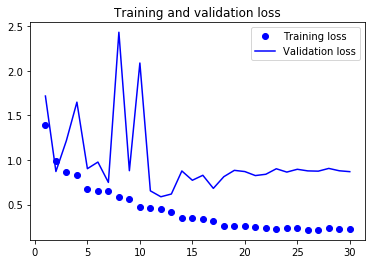

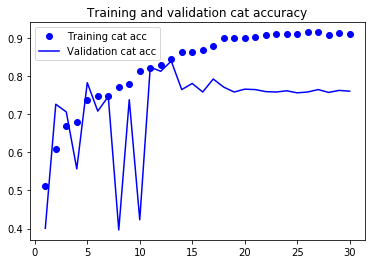

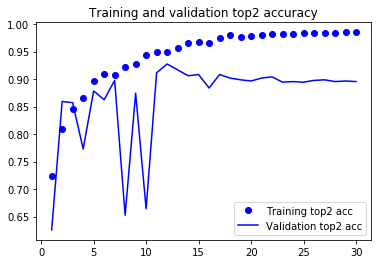

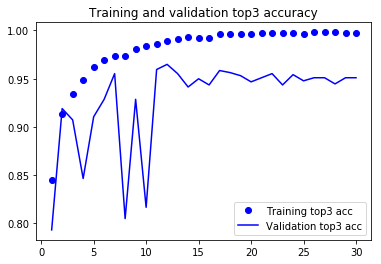

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [ ]:
test_labels = test_batches.classes

In [ ]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

938/938 [==============================] - 13s 14ms/step


In [ ]:
predictions.shape

(938, 7)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [ ]:
test_labels.shape

(938,)

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 14   7   0   3   0   2   0]
 [  1  27   0   1   0   1   0]
 [ 18  10   8   2   5  32   0]
 [  0   0   0   3   0   3   0]
 [  3   6   0   1   7  21   1]
 [  4  21   0  25   5 695   1]
 [  0   0   0   0   0   3   8]]


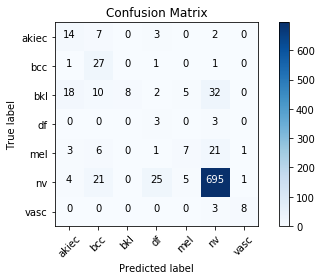

In [ ]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [ ]:
y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

             precision    recall  f1-score   support

      akiec       0.35      0.54      0.42        26
        bcc       0.38      0.90      0.53        30
        bkl       1.00      0.11      0.19        75
         df       0.09      0.50      0.15         6
        mel       0.41      0.18      0.25        39
         nv       0.92      0.93      0.92       751
       vasc       0.80      0.73      0.76        11

avg / total       0.86      0.81      0.80       938



In [ ]:
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk
